In [4]:
import torch
import torchvision
import torchvision.transforms as tr
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import numpy as np
import pandas as pd
import cv2
import torchsummary
from sklearn.metrics import recall_score
from glob import glob
import os


import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings(action='ignore')
from os.path import isfile, join, abspath, exists, isdir, expanduser
from torchvision import transforms, datasets, models
from PIL import Image


In [2]:
GPU_NUM = 2 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
print ('Current cuda device ', torch.cuda.current_device()) # check

# Infos
if device.type == 'cuda':
    print(torch.cuda.get_device_name(GPU_NUM))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(GPU_NUM)/1024**3,1), 'GB')


Current cuda device  2
TITAN Xp
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [ ]:
img_dir = '../datasets/emart24/beverage'
#img_dir = '../datasets/test'


result = []
idx = 0

label_list = [f for f in os.listdir(img_dir) if not f.startswith('.')]
num_to_class = dict(zip(range(len(label_list)), label_list))

for label in num_to_class:
    file_list = glob(os.path.join(img_dir,num_to_class[label],'*'))
    
    for file in file_list:
        result.append(['Train_{}'.format(idx), idx, label, num_to_class[label], file])
        idx += 1

df_train = pd.DataFrame(result, columns=['image_id','idx','num_label','cate_label','image'])


In [6]:
data_dir = '../datasets/emart24/beverage/'
img_dir = '../datasets/emart24/beverage'
cache_dir = expanduser(join('~', '.torch'))

image_size = 224
batch_size = 84

label_list = [f for f in os.listdir(img_dir) if not f.startswith('.')]
classes = os.listdir(data_dir)
#classes = sorted(classes, key=lambda item: (int(item.partition(' ')[0])
                               #if item[0].isdigit() else float('inf'), item))
num_to_class = dict(zip(range(len(classes)), classes))
num_to_class

{0: 'gal_bae_can',
 1: 'demisoda',
 2: 'peach',
 3: 'power',
 4: 'fanta_pine_pet',
 5: 'mango',
 6: 'milkis_pet',
 7: 'vita_500',
 8: 'apple_pet',
 9: 'mccol',
 10: 'fanta_orange_pet',
 11: 'dailyC',
 12: 'grape',
 13: 'sprite_pet',
 14: 'milkis_can',
 15: 'sprite_can',
 16: 'coca_can',
 17: 'sol',
 18: 'gas_hwal',
 19: 'aloe_pet',
 20: '2%_peach_pet',
 21: 'mogumogu',
 22: 'coca_pet',
 23: 'virak_pet',
 24: 'tejava',
 25: 'lemonade',
 26: 'hongsam',
 27: 'pocari',
 28: 'pepsi_can',
 29: 'pepsi_pet',
 30: 'gal_bae_pet',
 31: 'jeju_pet',
 32: '2%_can',
 33: 'red_bull',
 34: 'welchs',
 35: 'oranC'}

In [7]:
train = []
for index, label in enumerate(classes):
    path = data_dir +'/'+ label + '/'
    for file in os.listdir(path):
        train.append(['{}/{}'.format(label, file), label, index])
    
df = pd.DataFrame(train, columns=['file', 'category', 'category_id',]) 
df

,file,category,category_id
0,gal_bae_can/2253.jpg,gal_bae_can,0
1,gal_bae_can/450.jpg,gal_bae_can,0
2,gal_bae_can/2317.jpg,gal_bae_can,0
3,gal_bae_can/3972.jpg,gal_bae_can,0
4,gal_bae_can/4156.jpg,gal_bae_can,0
...,...,...,...
30555,oranC/723.jpg,oranC,35
30556,oranC/263.jpg,oranC,35
30557,oranC/1914.jpg,oranC,35
30558,oranC/4476.jpg,oranC,35


In [8]:
train_data = df.sample(frac=0.8)
valid_data = df[~df['file'].isin(train_data['file'])]

In [10]:
class SeedlingDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = self.labels.iloc[idx, 0]
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname).convert('RGB')
        labels = self.labels.iloc[idx, 2]
        if self.transform:
            image = self.transform(image)
        return image, int(labels)

In [31]:
df_fold = pd.read_csv('./train_fold_t.csv')

In [45]:
df_fold

,image_id,idx,num_label,cate_label,image,fold
0,Train_0,0,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/2253.jpg,8
1,Train_1,1,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/450.jpg,7
2,Train_2,2,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/2317.jpg,8
3,Train_3,3,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/3972.jpg,8
4,Train_4,4,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/4156.jpg,1
...,...,...,...,...,...,...
30555,Train_30555,30555,35,oranC,../datasets/emart24/beverage/oranC/723.jpg,9
30556,Train_30556,30556,35,oranC,../datasets/emart24/beverage/oranC/263.jpg,3
30557,Train_30557,30557,35,oranC,../datasets/emart24/beverage/oranC/1914.jpg,1
30558,Train_30558,30558,35,oranC,../datasets/emart24/beverage/oranC/4476.jpg,0


In [41]:
class SeedlingDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        #img_id = self.img_ids[index]
        img = cv2.imread(df_fold['image'][index]).astype(np.uint8)
        #img = img.reshape(self.img_height, self.img_width).astype(np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        #labels = self.labels.iloc[idx, 2]
        labels = self.labels.iloc[index].num_label
        if self.transform:
            image = self.transform(image)
        return image, int(labels)

In [42]:
val_set = 5

trn_fold = [i for i in range(10) if i not in [val_set]]
vld_fold = [val_set]

trn_idx = df_fold.loc[df_fold['fold'].isin(trn_fold)].index
vld_idx = df_fold.loc[df_fold['fold'].isin(vld_fold)].index

In [43]:
train_trans = transforms.Compose([
    transforms.RandomSizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_trans = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#train_set = SeedlingDataset(train_data, data_dir + '/', transform = train_trans)
#valid_set = SeedlingDataset(valid_data, data_dir + '/', transform = valid_trans)
#test_set = SeedlingDataset(sample_submission, data_dir + 'test/', transform = valid_trans)
train_set = SeedlingDataset(df_fold.loc[trn_idx], data_dir + '/', transform = train_trans)
valid_set = SeedlingDataset(df_fold.loc[vld_idx], data_dir + '/', transform = valid_trans)


train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=1)
#test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

dataset_sizes = {
    'train': len(train_loader.dataset), 
    'valid': len(valid_loader.dataset)
}

In [36]:
import pretrainedmodels

model_name = 'resnet50'
backbone = pretrainedmodels.__dict__[model_name](pretrained='imagenet')
in_features = backbone.last_linear.in_features
backbone.last_linear = nn.Linear(in_features, len(label_list))

In [37]:
model = backbone.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fn = nn.CrossEntropyLoss()
sheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                     mode='max',
                                                     verbose=True,
                                                     patience=7,
                                                     factor=0.5)

In [44]:
best_score = -1
EPOCH = 100
#model = torch.nn.DataParallel(model, device_ids=[1,2]).cuda()

for epoch in range(EPOCH):
    train_loss = []
    model.train()
    
    for inputs, targets in tqdm_notebook(train_loader):
        
        inputs = inputs.cuda()
        targets = targets.cuda()
        
        result = model(inputs)
        
        loss = loss_fn(result, targets)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.item())
        
    val_loss = []
    val_true = []
    val_pred = []
    
    model.eval()
    
    with torch.no_grad():
        
        for vld_inputs, vld_targets in tqdm_notebook(valid_loader):
            
            vld_inputs = vld_inputs.cuda()
            vld_targets = vld_targets.cuda()
            
            result = model(vld_inputs)
            
            val_loss.append(loss.item())
            
            result = result.cpu().argmax(dim=1).data.numpy()
            
            val_true.append(vld_targets.cpu().numpy())
            #val_pred.append(np.stack([result], axis=1))
            val_pred.append(result)
            
    val_true = np.concatenate(val_true)
    val_pred = np.concatenate(val_pred)
    
    val_loss = np.mean(val_loss)
    train_loss = np.mean(train_loss)
    
    score = recall_score(val_true, val_pred, average='macro')
    

    print(f'EPOCH:{epoch}, train_loss: {train_loss:.5f}, val_loss:{val_loss:.5f}, recall:{score:.5f}')
    if score > best_score:
        best_score = score

        state_dict = model.cpu().state_dict()
        model = model.cuda()
        torch.save(state_dict, 'model_feature.pt')
        torch.save(model,'model_total.pt')

UnboundLocalError: Caught UnboundLocalError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-41-f22d07b346e3>", line 19, in __getitem__
    image = self.transform(image)
UnboundLocalError: local variable 'image' referenced before assignment


TypeError: new(): data must be a sequence (got JpegImageFile)

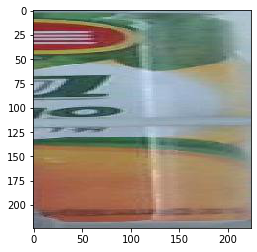

In [23]:
# 파일 infer
#filepath = './model.pt'

#tt.load_state_dict(torch.load(filepath))
#tt.eval()


#img = cv2.imread('./data/3.jpg').astype(np.uint8)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = Image.open('./data/3.jpg')

plt.imshow(img)

img = torch.FloatTensor(img).permute(2,1,0).unsqueeze(0)

result = model.cuda()(img.cuda())
torch.max(result,1)[1].cpu().numpy()
num_to_class[torch.max(result,1)[1].cpu().numpy()[0]]

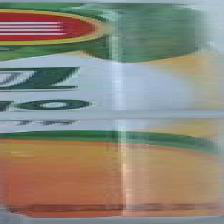

In [30]:
Image.open('./data/3.jpg').convert('RGB')

In [25]:
val_true

array([20, 13, 15, ..., 15, 19, 31])

In [26]:
val_pred

array([20, 13, 15, ..., 15, 19, 31])